In [1]:
import readgadget
import readfof
import bigfile
import nbodykit
import sys, os
import nbodykit.lab as nb
import readgadget
import numpy as np
import matplotlib.pyplot as pl
from ngp_mass import NGP_mass
import dill
from tqdm import tqdm
import sparse
import MAS_library as MASL
import colossus
from colossus.cosmology import cosmology
from colossus.halo import mass_so
from colossus.lss import peaks
from colossus.halo import concentration


In [3]:

def save_halo_cats(isim, mass_type='fof', isfid=False, 
                z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0, -1: 127}, snapnum = 3,
                grid = 128, BoxSize = 1000.,Mmin_cut = 5e12,Mmin_cut_str = '5e12',
                save_subvol = True, save_full = True, save_vel=True,
                LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'):
    
    
    
    redshift = z_dict[snapnum]
    # mass_type = 'rockstar_200c'

    if isfid:
        cosmo_val_all = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
    else:
        cosmo_val_all = np.loadtxt(LH_cosmo_val_file)[isim]

    Om0 = cosmo_val_all[0]
    Ob0 = cosmo_val_all[1]
    h0 = cosmo_val_all[2]
    ns = cosmo_val_all[3]
    sigma8 = cosmo_val_all[4]
    params = {'flat': True, 'H0': h0*100, 'Om0': Om0, 'Ob0': Ob0, 'sigma8': sigma8, 'ns': ns}
    cosmo = cosmology.setCosmology('myCosmo', **params)

    if 'rockstar' in mass_type:
        if isfid:
            snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'        
        else:            
            snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
        verbose = False   #print information on progress
        snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
        rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
        with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
            lines = f.readlines()
        header = lines[0].split()
        # get the properties of the halos
        pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
        if '200c' in mass_type:
            index_M = header.index('M200c')                    
            mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
            Rhalo = (1+redshift)*mass_so.M_to_R(mass_truth, redshift, '200c')        
        
        if 'vir' in mass_type:
            index_M = header.index('Mvir')
            mass_truth = rockstar[:,index_M]
            index_R = header.index('Rvir')
            Rhalo = rockstar[:,index_R]

        Rs = rockstar[:,header.index('Rs')]
        conc_sim = Rhalo/Rs
        
        lgMass_truth = np.log10(mass_truth).astype(np.float32)
        vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

    if 'fof' in mass_type:
        if isfid:
            snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/fiducial_HR' 
        else:
            snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/latin_hypercube_HR'
        snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
        FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
        # get the properties of the halos
        pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
        mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h
        lgMass_truth = np.log10(mass_truth).astype(np.float32)
        vel_h_truth = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s

        conc = np.zeros_like(mass_truth)

    

    
    
    n_batch = 8

    if isfid:
        root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    else:
        root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
    folder_out = '%s/%d'%(root_out,isim)
    # create output folder if it does not exists
    if not(os.path.exists(folder_out)):
        os.system('mkdir %s'%folder_out)

    savefname_halos_subvol = '%s/SPARSEMATS_halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,redshift)
    savefname_halos_full = '%s/SPARSEMATS_halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,redshift)            

    indsel = np.where(mass_truth > Mmin_cut)[0]
    pos_h_truth = pos_h_truth[indsel]
    mass_truth = mass_truth[indsel]
    lgMass_truth = lgMass_truth[indsel]
    vel_h_truth = vel_h_truth[indsel]
    # nu = peaks.peakHeight(mass_truth, redshift)
    conc_sim = conc_sim[indsel]
    conc_func = concentration.concentration(mass_truth, '200c', redshift, model = 'diemer19')
    delta_conc = conc_sim - conc_func 

    from scipy.interpolate import RegularGridInterpolator
    xall = (np.linspace(0, BoxSize, grid + 1))
    xarray = 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)

    if save_vel:
        import pickle as pk
        if isfid:
            vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/'
        else:
            vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
        df = pk.load(open(vel_load_dir + f'{isim}/velocity_HR_full_m_res_128_z={redshift}_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))['velocity_cic_unpad_combined']
        vx_mesh_load = 1000.*df[0,...]
        vy_mesh_load = 1000.*df[1,...]
        vz_mesh_load = 1000.*df[2,...]

        vx_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vx_mesh_load, bounds_error=False, fill_value=None)
        vy_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vy_mesh_load, bounds_error=False, fill_value=None)
        vz_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vz_mesh_load, bounds_error=False, fill_value=None)

        vx_eval_interp_l = vx_all_3D_interp_l(pos_h_truth)
        vy_eval_interp_l = vy_all_3D_interp_l(pos_h_truth)
        vz_eval_interp_l = vz_all_3D_interp_l(pos_h_truth)

        vx_diff = vel_h_truth[:,0] - vx_eval_interp_l
        vy_diff = vel_h_truth[:,1] - vy_eval_interp_l
        vz_diff = vel_h_truth[:,2] - vz_eval_interp_l


    Nhalos = np.float32(np.zeros((grid, grid, grid)))
    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
    print('max number of halos:', np.amax(Nhalos))

    if grid == 64:
        nMax_h = 30  # maximum number of halos expected in a cell
    elif grid == 128:
        nMax_h = 20
    elif grid == 256:
        nMax_h = 8
    elif grid == 512:
        nMax_h = 3
    elif grid == 1024:
        nMax_h = 2
    else:
        print('nside not supported')
        sys.exit()

    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)

    # dfhalo_ngp_wnu = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    # NGP_mass(np.float32(pos_h_truth), np.float32(nu), dfhalo_ngp_wnu, BoxSize)    

    dfhalo_ngp_wconc_sim = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(conc_sim), dfhalo_ngp_wconc_sim, BoxSize)        

    dfhalo_ngp_wconc_func = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(conc_func), dfhalo_ngp_wconc_func, BoxSize)            

    dfhalo_ngp_wconc_diff = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(delta_conc), dfhalo_ngp_wconc_diff, BoxSize)

    dfhalo_ngp_wvx_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    dfhalo_ngp_wvy_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    dfhalo_ngp_wvz_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    dfhalo_ngp_wvx_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    dfhalo_ngp_wvy_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    dfhalo_ngp_wvz_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))

    if save_vel:
        NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,0]), dfhalo_ngp_wvx_true, BoxSize)
        NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,1]), dfhalo_ngp_wvy_true, BoxSize)
        NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,2]), dfhalo_ngp_wvz_true, BoxSize)
        NGP_mass(np.float32(pos_h_truth), np.float32(vx_eval_interp_l), dfhalo_ngp_wvx_pred, BoxSize)
        NGP_mass(np.float32(pos_h_truth), np.float32(vy_eval_interp_l), dfhalo_ngp_wvy_pred, BoxSize)
        NGP_mass(np.float32(pos_h_truth), np.float32(vz_eval_interp_l), dfhalo_ngp_wvz_pred, BoxSize)

    argsort_M = np.flip(np.argsort(dfhalo_ngp_wmass, axis=-1), axis=-1)

    # M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)
    M_halos = np.take_along_axis(dfhalo_ngp_wmass, argsort_M, axis=-1)
    # nu_halos = np.take_along_axis(dfhalo_ngp_wnu, argsort_M, axis=-1)
    conc_sim_halos = np.take_along_axis(dfhalo_ngp_wconc_sim, argsort_M, axis=-1)
    conc_func_halos = np.take_along_axis(dfhalo_ngp_wconc_func, argsort_M, axis=-1)
    conc_diff_halos = np.take_along_axis(dfhalo_ngp_wconc_diff, argsort_M, axis=-1)
    dfhalo_ngp_wvx_true = np.take_along_axis(dfhalo_ngp_wvx_true, argsort_M, axis=-1)
    dfhalo_ngp_wvy_true = np.take_along_axis(dfhalo_ngp_wvy_true, argsort_M, axis=-1)
    dfhalo_ngp_wvz_true = np.take_along_axis(dfhalo_ngp_wvz_true, argsort_M, axis=-1)
    dfhalo_ngp_wvx_pred = np.take_along_axis(dfhalo_ngp_wvx_pred, argsort_M, axis=-1)
    dfhalo_ngp_wvy_pred = np.take_along_axis(dfhalo_ngp_wvy_pred, argsort_M, axis=-1)
    dfhalo_ngp_wvz_pred = np.take_along_axis(dfhalo_ngp_wvz_pred, argsort_M, axis=-1)


    dfhalo_ngp_wvall_true = np.moveaxis(np.array([dfhalo_ngp_wvx_true, dfhalo_ngp_wvy_true, dfhalo_ngp_wvz_true]), 0, -1)
    dfhalo_ngp_wvall_pred = np.moveaxis(np.array([dfhalo_ngp_wvx_pred, dfhalo_ngp_wvy_pred, dfhalo_ngp_wvz_pred]), 0, -1)
    dfhalo_ngp_wvall_diff =  dfhalo_ngp_wvall_pred - dfhalo_ngp_wvall_true


    if save_subvol:
        # now split it into nbatches each side
        subvol_size = grid // n_batch
        nsubvol = n_batch**3
        save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
        save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
        # save_subvol_nuhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
        save_subvol_concsimhalos = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
        save_subvol_concfunchalos = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
        save_subvol_concdiffhalos = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
        save_subvol_vtrue = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))
        save_subvol_vpred = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))
        save_subvol_vdiff = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))

        jc = 0
        from tqdm import tqdm
        for jx in (range(n_batch)):
            for jy in range(n_batch):
                for jz in range(n_batch):
                    # get the sub-cube
                    save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]
                    save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]

                    # save_subvol_nuhalo[jc] = nu_halos[jx * subvol_size:(jx + 1) * subvol_size,
                    #                                 jy * subvol_size:(jy + 1) * subvol_size,
                    #                                 jz * subvol_size:(jz + 1) * subvol_size]
                    
                    save_subvol_concsimhalos[jc] = conc_sim_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]

                    save_subvol_concfunchalos[jc] = conc_func_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]
                    save_subvol_concdiffhalos[jc] = conc_diff_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]

                    save_subvol_vtrue[jc] = dfhalo_ngp_wvall_true[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]

                    save_subvol_vpred[jc] = dfhalo_ngp_wvall_pred[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]

                    save_subvol_vdiff[jc] = dfhalo_ngp_wvall_diff[jx * subvol_size:(jx + 1) * subvol_size,
                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                    jz * subvol_size:(jz + 1) * subvol_size]


                    jc += 1

        save_subvol_Nhalo = sparse.COO(save_subvol_Nhalo)
        save_subvol_Mhalo = sparse.COO(save_subvol_Mhalo)
        # save_subvol_nuhalo = sparse.COO(save_subvol_nuhalo)
        save_subvol_concsimhalos = sparse.COO(save_subvol_concsimhalos)
        save_subvol_concfunchalos = sparse.COO(save_subvol_concfunchalos)
        save_subvol_concdiffhalos = sparse.COO(save_subvol_concdiffhalos)
        save_subvol_vtrue = sparse.COO(save_subvol_vtrue)
        save_subvol_vpred = sparse.COO(save_subvol_vpred)
        save_subvol_vdiff = sparse.COO(save_subvol_vdiff)
        saved_halos_subvol = {
            'N_halos': save_subvol_Nhalo,
            'M_halos': save_subvol_Mhalo,
            # 'nu_halos': save_subvol_nuhalo,
            'c_halos_sim': save_subvol_concsimhalos,
            'c_halos_func': save_subvol_concfunchalos,
            'c_halos_diff': save_subvol_concdiffhalos,
            'v_halos_true': save_subvol_vtrue,
            'v_halos_pred': save_subvol_vpred,
            'v_halos_diff': save_subvol_vdiff
            }    
        dill.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

    if save_full:
        Nhalos = sparse.COO(Nhalos)
        M_halos = sparse.COO(M_halos)
        # nu_halos = sparse.COO(nu_halos)
        conc_sim_halos = sparse.COO(conc_sim_halos)
        conc_func_halos = sparse.COO(conc_func_halos)
        conc_diff_halos = sparse.COO(conc_diff_halos)
        dfhalo_ngp_wvall_true = sparse.COO(dfhalo_ngp_wvall_true)
        dfhalo_ngp_wvall_pred = sparse.COO(dfhalo_ngp_wvall_pred)
        dfhalo_ngp_wvall_diff = sparse.COO(dfhalo_ngp_wvall_diff)
        saved_halos_full = {
            'N_halos_combined': Nhalos,
            'M_halos_combined': M_halos,
            # 'nu_halos_combined': nu_halos,
            'c_halos_sim_combined': conc_sim_halos,
            'c_halos_func_combined': conc_func_halos,
            'c_halos_diff_combined': conc_diff_halos,
            'v_halos_true_combined': dfhalo_ngp_wvall_true,
            'v_halos_pred_combined': dfhalo_ngp_wvall_pred,
            'v_halos_diff_combined': dfhalo_ngp_wvall_diff
            }    
        dill.dump(saved_halos_full, open(savefname_halos_full, 'wb'))



import multiprocessing as mp
do_mp = 0
isfid = 1
if __name__ == '__main__':
    n_sims_offset = 0
    n_sims = 2

    if do_mp:
        n_cores = mp.cpu_count()
        print(n_cores)

        # Create a pool of worker processes
        pool = mp.Pool(processes=n_cores)

        # Distribute the simulations across the available cores
        sims_per_core = n_sims // n_cores
        sim_ranges = [(n_sims_offset + i * sims_per_core, n_sims_offset + (i + 1) * sims_per_core) for i in range(n_cores)]

        # Handle any remaining simulations
        remaining_sims = n_sims % n_cores
        if remaining_sims > 0:
            sim_ranges[-1] = (sim_ranges[-1][0], sim_ranges[-1][1] + remaining_sims)

        # Run save_cic_densities function for each simulation range in parallel
        results = [pool.apply_async(save_halo_cats, args=(ji,)) for sim_range in sim_ranges for ji in range(*sim_range)]

        # Wait for all tasks to complete
        [result.get() for result in results]

        # Close the pool and wait for tasks to finish
        pool.close()
        pool.join()
    else:
        for ji in range(n_sims_offset, n_sims_offset + n_sims):
            save_halo_cats(ji, mass_type='rockstar_200c', isfid=isfid, snapnum=3, save_subvol=1, save_full=1, save_vel=1)


/tmp/ipykernel_147954/256442342.py:52: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


max number of halos: 18.0


/tmp/ipykernel_147954/256442342.py:52: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


max number of halos: 22.0


In [2]:
isim = 0
mass_type='rockstar_200c'
isfid=True
z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0, -1: 127}
snapnum = 3
grid = 128
BoxSize = 1000.
Mmin_cut = 5e12
Mmin_cut_str = '5e12',
save_subvol = True
save_full = True
save_vel=True
LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'

redshift = z_dict[snapnum]
# mass_type = 'rockstar_200c'

if isfid:
    cosmo_val_all = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
else:
    cosmo_val_all = np.loadtxt(LH_cosmo_val_file)[isim]

Om0 = cosmo_val_all[0]
Ob0 = cosmo_val_all[1]
h0 = cosmo_val_all[2]
ns = cosmo_val_all[3]
sigma8 = cosmo_val_all[4]
params = {'flat': True, 'H0': h0*100, 'Om0': Om0, 'Ob0': Ob0, 'sigma8': sigma8, 'ns': ns}
cosmo = cosmology.setCosmology('myCosmo', **params)

if 'rockstar' in mass_type:
    if isfid:
        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'        
    else:            
        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
    verbose = False   #print information on progress
    snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()
    # get the properties of the halos
    pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
    if '200c' in mass_type:
        index_M = header.index('M200c')                    
        mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
        Rhalo = (1+redshift)*mass_so.M_to_R(mass_truth, redshift, '200c')        
    
    if 'vir' in mass_type:
        index_M = header.index('Mvir')
        mass_truth = rockstar[:,index_M]
        index_R = header.index('Rvir')
        Rhalo = rockstar[:,index_R]

    Rs = rockstar[:,header.index('Rs')]
    conc_sim = Rhalo/Rs
    
    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

if 'fof' in mass_type:
    if isfid:
        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/fiducial_HR' 
    else:
        snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/latin_hypercube_HR'
    snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
    FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
    # get the properties of the halos
    pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
    mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h
    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    vel_h_truth = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s

    conc = np.zeros_like(mass_truth)





n_batch = 8

if isfid:
    root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self'
else:
    root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
folder_out = '%s/%d'%(root_out,isim)
# create output folder if it does not exists
if not(os.path.exists(folder_out)):
    os.system('mkdir %s'%folder_out)

savefname_halos_subvol = '%s/SPARSEMATS_halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,redshift)
savefname_halos_full = '%s/SPARSEMATS_halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,redshift)            

indsel = np.where(mass_truth > Mmin_cut)[0]
pos_h_truth = pos_h_truth[indsel]
mass_truth = mass_truth[indsel]
lgMass_truth = lgMass_truth[indsel]
vel_h_truth = vel_h_truth[indsel]
# nu = peaks.peakHeight(mass_truth, redshift)
conc_sim = conc_sim[indsel]
conc_func = concentration.concentration(mass_truth, '200c', redshift, model = 'diemer19')
# conc_func = conc_func[indsel]
delta_conc = conc_sim - conc_func 

from scipy.interpolate import RegularGridInterpolator
xall = (np.linspace(0, BoxSize, grid + 1))
xarray = 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)

if save_vel:
    import pickle as pk
    if isfid:
        vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/'
    else:
        vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
    df = pk.load(open(vel_load_dir + f'{isim}/velocity_HR_full_m_res_128_z={redshift}_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))['velocity_cic_unpad_combined']
    vx_mesh_load = 1000.*df[0,...]
    vy_mesh_load = 1000.*df[1,...]
    vz_mesh_load = 1000.*df[2,...]

    vx_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vx_mesh_load, bounds_error=False, fill_value=None)
    vy_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vy_mesh_load, bounds_error=False, fill_value=None)
    vz_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vz_mesh_load, bounds_error=False, fill_value=None)

    vx_eval_interp_l = vx_all_3D_interp_l(pos_h_truth)
    vy_eval_interp_l = vy_all_3D_interp_l(pos_h_truth)
    vz_eval_interp_l = vz_all_3D_interp_l(pos_h_truth)

    vx_diff = vel_h_truth[:,0] - vx_eval_interp_l
    vy_diff = vel_h_truth[:,1] - vy_eval_interp_l
    vz_diff = vel_h_truth[:,2] - vz_eval_interp_l


Nhalos = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
print('max number of halos:', np.amax(Nhalos))

if grid == 64:
    nMax_h = 30  # maximum number of halos expected in a cell
elif grid == 128:
    nMax_h = 20
elif grid == 256:
    nMax_h = 8
elif grid == 512:
    nMax_h = 3
elif grid == 1024:
    nMax_h = 2
else:
    print('nside not supported')
    sys.exit()

dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)

# dfhalo_ngp_wnu = np.float32(np.zeros((grid, grid, grid, nMax_h)))
# NGP_mass(np.float32(pos_h_truth), np.float32(nu), dfhalo_ngp_wnu, BoxSize)    

dfhalo_ngp_wconc_sim = np.float32(np.zeros((grid, grid, grid, nMax_h)))
NGP_mass(np.float32(pos_h_truth), np.float32(conc_sim), dfhalo_ngp_wconc_sim, BoxSize)        

dfhalo_ngp_wconc_func = np.float32(np.zeros((grid, grid, grid, nMax_h)))
NGP_mass(np.float32(pos_h_truth), np.float32(conc_func), dfhalo_ngp_wconc_func, BoxSize)            

dfhalo_ngp_wconc_diff = np.float32(np.zeros((grid, grid, grid, nMax_h)))
NGP_mass(np.float32(pos_h_truth), np.float32(delta_conc), dfhalo_ngp_wconc_diff, BoxSize)

dfhalo_ngp_wvx_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
dfhalo_ngp_wvy_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
dfhalo_ngp_wvz_true = np.float32(np.zeros((grid, grid, grid, nMax_h)))
dfhalo_ngp_wvx_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
dfhalo_ngp_wvy_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))
dfhalo_ngp_wvz_pred = np.float32(np.zeros((grid, grid, grid, nMax_h)))

if save_vel:
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,0]), dfhalo_ngp_wvx_true, BoxSize)
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,1]), dfhalo_ngp_wvy_true, BoxSize)
    NGP_mass(np.float32(pos_h_truth), np.float32(vel_h_truth[:,2]), dfhalo_ngp_wvz_true, BoxSize)
    NGP_mass(np.float32(pos_h_truth), np.float32(vx_eval_interp_l), dfhalo_ngp_wvx_pred, BoxSize)
    NGP_mass(np.float32(pos_h_truth), np.float32(vy_eval_interp_l), dfhalo_ngp_wvy_pred, BoxSize)
    NGP_mass(np.float32(pos_h_truth), np.float32(vz_eval_interp_l), dfhalo_ngp_wvz_pred, BoxSize)

argsort_M = np.flip(np.argsort(dfhalo_ngp_wmass, axis=-1), axis=-1)

# M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)
M_halos = np.take_along_axis(dfhalo_ngp_wmass, argsort_M, axis=-1)
# nu_halos = np.take_along_axis(dfhalo_ngp_wnu, argsort_M, axis=-1)
conc_sim_halos = np.take_along_axis(dfhalo_ngp_wconc_sim, argsort_M, axis=-1)
conc_func_halos = np.take_along_axis(dfhalo_ngp_wconc_func, argsort_M, axis=-1)
conc_diff_halos = np.take_along_axis(dfhalo_ngp_wconc_diff, argsort_M, axis=-1)
dfhalo_ngp_wvx_true = np.take_along_axis(dfhalo_ngp_wvx_true, argsort_M, axis=-1)
dfhalo_ngp_wvy_true = np.take_along_axis(dfhalo_ngp_wvy_true, argsort_M, axis=-1)
dfhalo_ngp_wvz_true = np.take_along_axis(dfhalo_ngp_wvz_true, argsort_M, axis=-1)
dfhalo_ngp_wvx_pred = np.take_along_axis(dfhalo_ngp_wvx_pred, argsort_M, axis=-1)
dfhalo_ngp_wvy_pred = np.take_along_axis(dfhalo_ngp_wvy_pred, argsort_M, axis=-1)
dfhalo_ngp_wvz_pred = np.take_along_axis(dfhalo_ngp_wvz_pred, argsort_M, axis=-1)


dfhalo_ngp_wvall_true = np.moveaxis(np.array([dfhalo_ngp_wvx_true, dfhalo_ngp_wvy_true, dfhalo_ngp_wvz_true]), 0, -1)
dfhalo_ngp_wvall_pred = np.moveaxis(np.array([dfhalo_ngp_wvx_pred, dfhalo_ngp_wvy_pred, dfhalo_ngp_wvz_pred]), 0, -1)
dfhalo_ngp_wvall_diff =  dfhalo_ngp_wvall_pred - dfhalo_ngp_wvall_true


if save_subvol:
    # now split it into nbatches each side
    subvol_size = grid // n_batch
    nsubvol = n_batch**3
    save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
    save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
    # save_subvol_nuhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
    save_subvol_concsimhalos = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
    save_subvol_concfunchalos = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
    save_subvol_concdiffhalos = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
    save_subvol_vtrue = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))
    save_subvol_vpred = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))
    save_subvol_vdiff = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h, 3))

    jc = 0
    from tqdm import tqdm
    for jx in (range(n_batch)):
        for jy in range(n_batch):
            for jz in range(n_batch):
                # get the sub-cube
                save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                            jy * subvol_size:(jy + 1) * subvol_size,
                                            jz * subvol_size:(jz + 1) * subvol_size]
                save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                # save_subvol_nuhalo[jc] = nu_halos[jx * subvol_size:(jx + 1) * subvol_size,
                #                                 jy * subvol_size:(jy + 1) * subvol_size,
                #                                 jz * subvol_size:(jz + 1) * subvol_size]
                
                save_subvol_concsimhalos[jc] = conc_sim_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_concfunchalos[jc] = conc_func_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]
                save_subvol_concdiffhalos[jc] = conc_diff_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vtrue[jc] = dfhalo_ngp_wvall_true[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vpred[jc] = dfhalo_ngp_wvall_pred[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]

                save_subvol_vdiff[jc] = dfhalo_ngp_wvall_diff[jx * subvol_size:(jx + 1) * subvol_size,
                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                jz * subvol_size:(jz + 1) * subvol_size]


                jc += 1

/tmp/ipykernel_2689253/1750538383.py:58: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


max number of halos: 18.0


In [3]:
lgmass_bins_to_edges = np.linspace(12.8, 15.5, 11)
lgmass_bins = 0.5*(lgmass_bins_to_edges[1:] + lgmass_bins_to_edges[:-1])
conc_sim_average_bins = np.zeros_like(lgmass_bins)
conc_sim_sigma_bins = np.zeros_like(lgmass_bins)

delta_conc_sim_average_bins = np.zeros_like(lgmass_bins)
delta_conc_sim_sigma_bins = np.zeros_like(lgmass_bins)

conc_func_average_bins = np.zeros_like(lgmass_bins)
for ji in range(len(lgmass_bins)-1):
    ind = np.where((lgMass_truth > lgmass_bins[ji]) & (lgMass_truth < lgmass_bins[ji+1]))[0]
    conc_sim_average_bins[ji] = np.mean(conc_sim[ind])
    conc_sim_sigma_bins[ji] = np.std(conc_sim[ind])
    delta_conc_sim_average_bins[ji] = np.mean(delta_conc[ind])
    delta_conc_sim_sigma_bins[ji] = np.std(delta_conc[ind])
    conc_func_average_bins[ji] = np.mean(conc_func[ind])


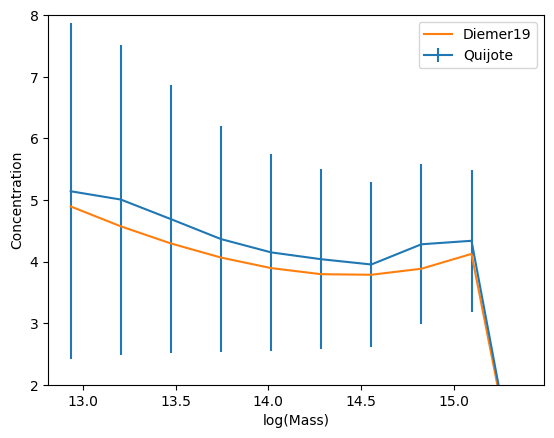

In [6]:
pl.figure()
pl.errorbar(lgmass_bins, conc_sim_average_bins, yerr=conc_sim_sigma_bins, label='Quijote')
pl.plot(lgmass_bins, conc_func_average_bins, label='Diemer19')
pl.ylim(2, 8)
pl.xlabel('log(Mass)')
pl.ylabel('Concentration')
pl.legend()
# pl.scatter(lgMass_truth, conc_func, s=0.1)



(-3.0, 3.0)

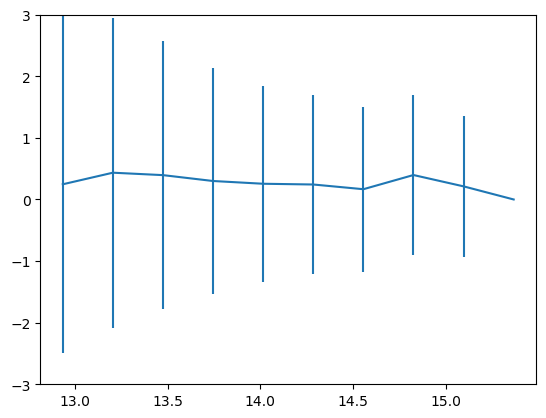

In [32]:
pl.figure()
pl.errorbar(lgmass_bins, delta_conc_sim_average_bins, yerr=delta_conc_sim_sigma_bins)
# pl.plot(lgmass_bins, conc_func_average_bins)
pl.ylim(-3, 3)

# pl.scatter(lgMass_truth, conc_func, s=0.1)



In [1]:
import sys, os
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
root_dir = '/mnt/home/spandey/ceph/CHARM/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from charm.utils_data_prep_cosmo_vel_conc_peak import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml
import pickle as pk
# autoreload modules
import matplotlib
import matplotlib.pyplot as pl


# run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128_lresdata.yaml'
# run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128_fof.yaml'
run_config_name = 'TRAIN_PEAK_FREECOSMO_cond_fastpm_ns128_vir.yaml'
with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
# K_M1 = config_net['K_M1']
# B_M1 = config_net['B_M1']
# nflows_M1_NSF = config_net['nflows_M1_NSF']

# K_Mdiff = config_net['K_Mdiff']
# B_Mdiff = config_net['B_Mdiff']
# nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

# base_dist_Ntot = config_net['base_dist_Ntot']
# if base_dist_Ntot == 'None':
#     base_dist_Ntot = None
# base_dist_M1 = config_net['base_dist_M1']
# base_dist_Mdiff = config_net['base_dist_Mdiff']
# ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    ninp = len(z_all_FP) + 2
    # if 'v' in z_all_FP
elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")



num_cond = nout_cnn + ninp + num_cosmo_params

import pickle as pk
import numpy as np

# df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, df_vh_train, df_ch_train, df_nuh_train, ind_subsel_all_train, ind_subsel_fid_train, cosmo_val_all_train = load_density_halo_data_NGP(
#     ji_array, ns_d, nb, nf, nc, z_all, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
#     sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
#     sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self',  
#     LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
#     stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria=subsel_criteria, is_HR = is_HR,  vel_type='diff',
#     get_density=False,
#     get_halos=True
#     )

# import sparse
# saved = {'df_d_all_train':df_d_all_train,
#             'df_d_all_nsh_train':df_d_all_nsh_train,
#             'df_Mh_all_train':sparse.COO(df_Mh_all_train),
#             'df_nuh_train':sparse.COO(df_nuh_train),
#             'df_ch_train':sparse.COO(df_ch_train),
#             'df_Nh_train':sparse.COO(df_Nh_train),
#             'df_vh_train':sparse.COO(df_vh_train),
#             'ind_subsel_all_train':ind_subsel_all_train,
#             'ind_subsel_fid_train':ind_subsel_fid_train,
#             'cosmo_val_all_train':cosmo_val_all_train
#             }

# import pickle as pk
# nsims = int(config_sims['nsims'])
# pk.dump(saved, open('/mnt/home/spandey/ceph/CHARM/data/' + f'TEMP_HALO_MASS_{mass_type}_VEL_NU_CONC_varycosmo_subsel_random_nsims{nsims}_nspji{nsubvol_per_ji}_nfid{nsubvol_fid}' + '_train_data_QUIJOTE.pk', 'wb'))

# import pickle as pk
# nsims = int(config_sims['nsims'])
# df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/' + f'HALO_MASS_VEL_varycosmo_subsel_random_nsims{nsims}_nspji{nsubvol_per_ji}_nfid{nsubvol_fid}' + '_train_data_QUIJOTE.pk', 'rb'))
# cosmo_val_all_train = df['cosmo_val_all_train']
# ind_subsel_all_train = df['ind_subsel_all_train']
# ind_subsel_fid_train = df['ind_subsel_fid_train']


# df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, df_vh_train_FP, df_ch_train_FP, df_nuh_train_FP, ind_subsel_all_train_FP, ind_subsel_fid_train_FP, cosmo_val_all_train_FP = load_density_halo_data_NGP(
#     ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
#     sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH',
#     sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',  
#     LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
#     stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria=subsel_criteria,
#     indsubsel_all_inp=ind_subsel_all_train,
#     indsubsel_fid_inp=ind_subsel_fid_train,
#     is_HR = is_HR,  vel_type='diff',
#     get_density=True,
#     get_halos=False
#     )
# if cosmo_val_all_train_FP is None:
#     cosmo_val_all_train_FP = cosmo_val_all_train



# saved = {'df_d_all_train':df_d_all_train_FP,
#             'df_d_all_nsh_train':df_d_all_nsh_train_FP,
#             'df_Mh_all_train':df_Mh_all_train_FP,
#             'df_nuh_train':df_nuh_train_FP,
#             'df_ch_train':df_ch_train_FP,
#             'df_Nh_train':df_Nh_train_FP,
#             'df_vh_train_FP':df_vh_train_FP,
#             'ind_subsel_all_train':ind_subsel_all_train_FP,
#             'ind_subsel_fid_train':ind_subsel_fid_train_FP,
#             'cosmo_val_all_train':cosmo_val_all_train_FP
#             }

# import pickle as pk
# nsims = int(config_sims['nsims'])
# pk.dump(saved, open('/mnt/home/spandey/ceph/CHARM/data/' + f'DENSITY_varycosmo_subsel_random_nsims{nsims}_nspji{nsubvol_per_ji}_nfid{nsubvol_fid}' + '_train_data_FASTPM.pk', 'wb'))





In [66]:
# df_nuh_train.shape

import pickle as pk
nsims = int(config_sims['nsims'])
df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/DENSITY_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_FASTPM.pk', 'rb'))
cosmo_val_all_train = df['cosmo_val_all_train']
ind_subsel_all_train = df['ind_subsel_all_train']
ind_subsel_fid_train = df['ind_subsel_fid_train']
df_d_all_nsh_train_FP = df['df_d_all_nsh_train']


In [67]:
# ind_subsel_all_train.shape, ind_subsel_fid_train.shape
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, df_vh_train, df_ch_train, df_nuh_train, ind_subsel_all_train, ind_subsel_fid_train, cosmo_val_all_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
    sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
    sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self',  
    LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria='ind', 
    indsubsel_all_inp=ind_subsel_all_train,
    indsubsel_fid_inp=ind_subsel_fid_train,
    is_HR = is_HR,  vel_type='diff',
    get_density=False,
    get_halos=True
    )




100%|██████████| 16/16 [00:42<00:00,  2.66s/it]


In [68]:
df_nuh_train.shape




(768, 16, 16, 16, 20)

In [69]:
# df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/DENSITY_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_FASTPM.pk', 'rb'))
df_d_all_nsh_train_FP = df['df_d_all_nsh_train']



In [70]:
df_d_all_nsh_train_FP.shape


(29312, 4, 16, 16, 16)

In [74]:
initv = df_d_all_nsh_train_FP.shape[0]-512
df_d_all_nsh_train_FP_sel = np.concatenate((df_d_all_nsh_train_FP[:256,...], df_d_all_nsh_train_FP[initv:,...]), axis=0)


In [37]:
df_nuh_train.shape, df_d_all_nsh_train_FP_sel.shape


((768, 16, 16, 16, 20), (768, 4, 16, 16, 16))

In [77]:
# df_d_all_nsh_train_FP_sel[0,:,0,0,0]
# nu_all = df_nuh_train[0:256,...,0].flatten()
# density_all = df_d_all_nsh_train_FP_sel[0:256,0,...].flatten()
nu_all = df_nuh_train[:,...,0].flatten()
density_all = df_d_all_nsh_train_FP_sel[:,0,...].flatten()


indsel = np.where(nu_all > 0)[0]
nu_all = nu_all[indsel]
density_all = density_all[indsel]


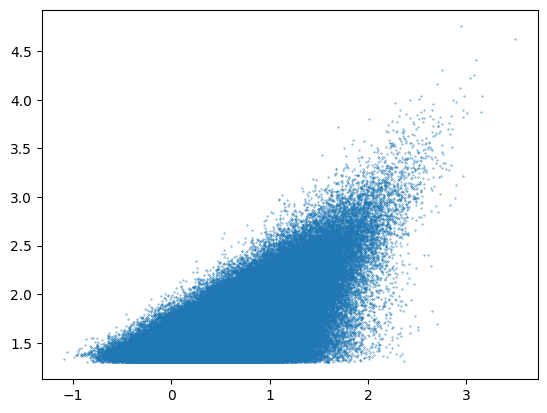

In [76]:
pl.figure()
pl.scatter(density_all, nu_all, s=0.1)



In [59]:
# df_d_all_nsh_train_FP_sel[:,0,...].shape, df_nuh_train[...,0].shape


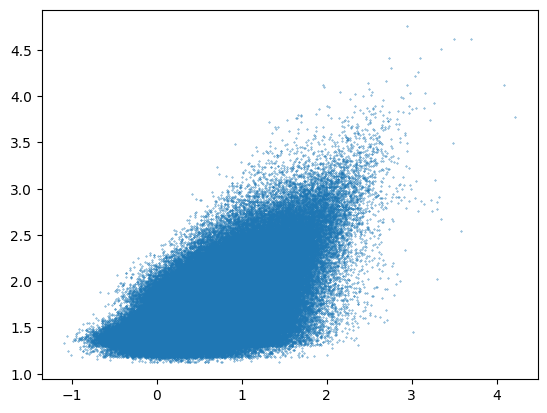

In [78]:
pl.figure()
pl.scatter(density_all, nu_all, s=0.1)



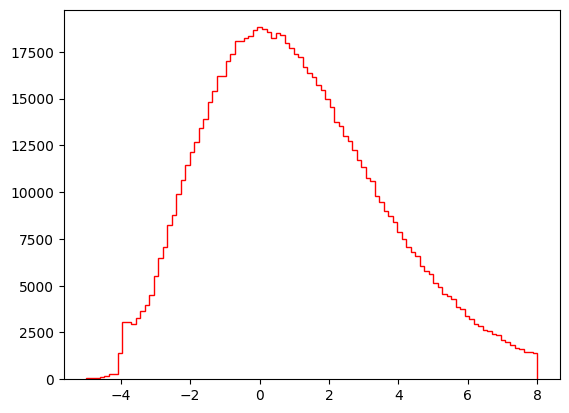

In [12]:
pl.figure()
# _ = pl.hist(df_nuh_train.flatten(), bins=100, histtype='step', color='r', label='Quijote')
df_ch_all = df_ch_train.flatten()
indsel = np.where(df_ch_all != 0)[0]
_ = pl.hist(df_ch_train.flatten()[indsel], bins=100, histtype='step', range=(-5,8), color='r', label='Quijote')
# pl.yscale('log')

